<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Shape Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 0

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 0

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "dog"

# Choose Whether to Train or Load a Model

In [0]:
# True = Load and output results for a model trained on the chosen dataset
# False = Train on the chosen dataset and output results 
LOAD_MODEL = False

# Provide the filename of the model to load/save
# Leave as None to use the default filename which will be named after the dataset
MODEL_NAME = None

# If LOAD_MODEL = False, choose whether to save the model
# True = Train and save
# False = Train only
SAVE_MODEL = True

# Define Training Hyper-Parameters


In [0]:
BATCH_SIZE = 32
LATENT_DIM = 1024
EPOCHS = 100

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from skimage import io
from skimage.transform import resize

TensorFlow 2.x selected.


# Dataset Setup

170500096/170498071 [==============================] - 4s 0us/step


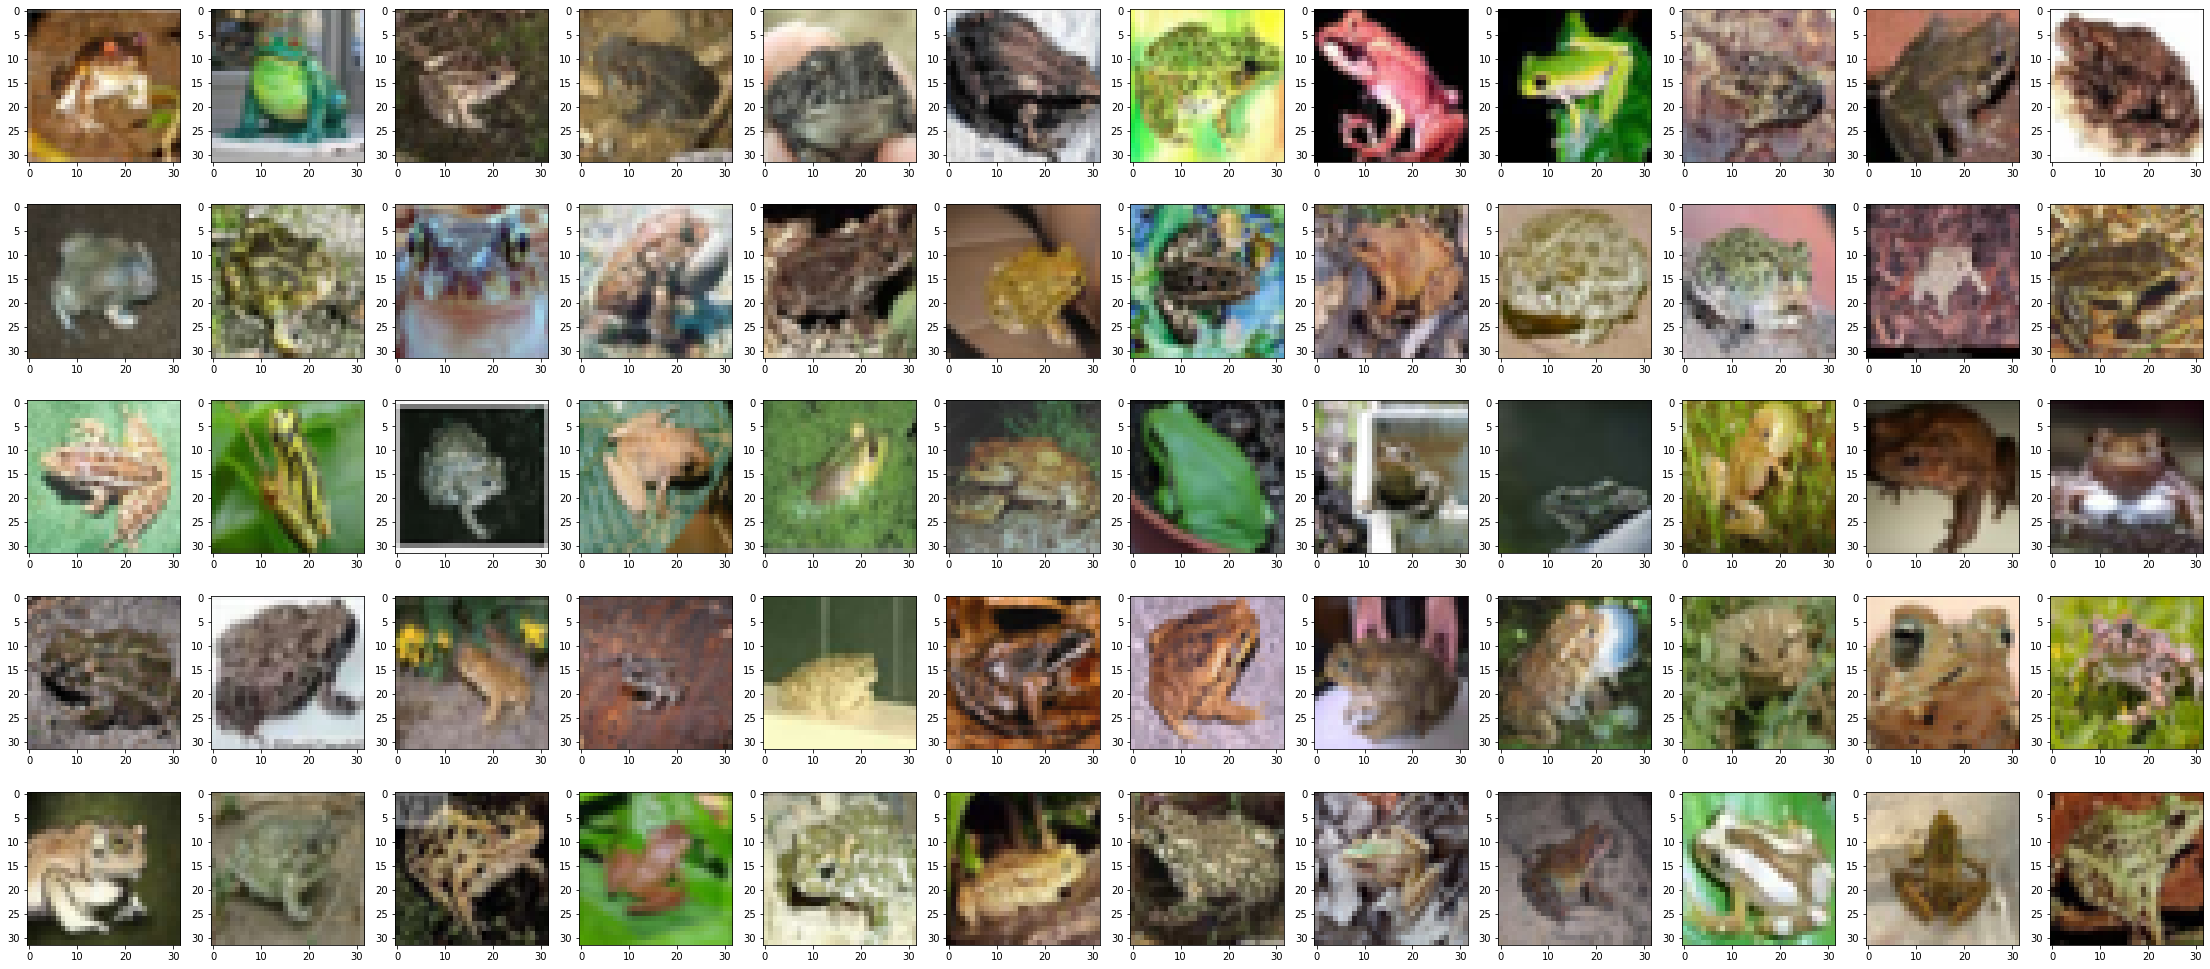

In [0]:
# Shape Set
if(DATASET_CHOICE == 0):
  BATCH_SIZE = 8 # Dataset too small for a 512 batch size
  
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/ShapeSet/ShapeSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/ShapeSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/ShapeSet"

  # Load and shuffle
  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    if(image.shape == (128, 128, 3)):
      images.append(np.array(image))
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  images = np.array(images)[indices]
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  # Scale pixel data to [0,1]
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Image output variables, change these to see different images on the results
  output_count = 9
  index_offset = 0

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(images[i])

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "ShapeSet"

# Cifar10
elif(DATASET_CHOICE == 1):
  # Load and scale dataset
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Prune dataset to chosen class
  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]
  
  # Output portion of the dataset
  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  # Image output variables, change these to see different images on the results
  output_count = 12
  index_offset = 20

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    if(CIFAR10_CLASS is not None):
      MODEL_NAME = "Cifar10-" + CIFAR10_CLASS
    else:
      MODEL_NAME = "Cifar10"

# Faces Images
elif(DATASET_CHOICE == 2):
  # Load and resize dataset
  !git clone https://github.com/2014mchidamb/DeepColorization/
  images = train_images = test_images = []
  for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
    images.append(resize(image, (128, 128)))
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 20
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Faces"

# Imagenette
elif(DATASET_CHOICE == 3):
  # Load and resize dataset
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/imagenette2-160/"
  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection(base_dir + "train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection(base_dir + "val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 0
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Imagenette-" + categories[IMAGENETTE_CATEGORY]

# Define the Training Encoder

In [0]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
# https://xiangyutang2.github.io/auto-colorization-autoencoders/

# Sampling with the reparametrisation trick
def sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

def slice_y(args):
    yuv_image = args
    return yuv_image[:,:,:,0]

def slice_uv(args):
    yuv_image = args
    return yuv_image[:,:,:,1:]

yuv_in = Input(shape=(train_yuv.shape[1], train_yuv.shape[2], train_yuv.shape[3]))
y_in = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))

# Define Training Encoder q(z|yuv)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(yuv_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space for encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_training = Dense(LATENT_DIM)(layer)
z_log_var_training = Dense(LATENT_DIM)(layer)
z_training = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_training, z_log_var_training]) # Data passable to the decoder

# Instantiate encoder 
encoder_training = Model(yuv_in, z_training, name='training_encoder')
encoder_training.summary()

Model: "training_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 16)     1168        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     9280        conv2d_1[0][0]                   
___________________________________________________________________________________

In [0]:
# Define Conditional Encoder p(z|y)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(y_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)

# Latent space for conditional encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_conditional = Dense(LATENT_DIM)(layer)
z_log_var_conditional = Dense(LATENT_DIM)(layer)
z_conditional = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_conditional, z_log_var_conditional]) # Data passable to the decoder

# Instantiate conditional encoder
encoder_conditional = Model(y_in, z_conditional, name='conditional_encoder')
encoder_conditional.summary()

Model: "conditional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 16)     1168        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 4, 4, 64)     9280        conv2d_5[0][0]                   
________________________________________________________________________________

In [0]:
# Define Decoder p(yuv|z,y)
latent_inputs = Input(shape=(LATENT_DIM,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
uv_out = Conv2DTranspose(filters=2, kernel_size=3, activation='tanh', padding='same')(layer)
concat_outputs = concatenate([uv_out, y_in], 3)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(concat_outputs)
yuv_out = Conv2DTranspose(filters=3, kernel_size=3, activation='tanh', padding='same')(layer)

# Instantiate Decoder
decoder = Model([latent_inputs, y_in], yuv_out, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          524800      input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 2, 128)    0           dense_6[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 4, 4, 128)    147584      reshape[0][0]                    
____________________________________________________________________________________________

In [0]:
# TODO: CLEAN UP THIS LOSS FUNCTION AND FIND A SUITABLE SIZE FOR RECONSTRUCTION

# Instantiate VAE
training_yuv_out = decoder([z_training, y_in])
training_vae = Model([yuv_in, y_in], training_yuv_out, name='training_vae')
# training_vae.summary()

# Reconstruction loss
reconstruction_loss = K.sum(mse(yuv_in, training_yuv_out))
reconstruction_loss *= (train_yuv.shape[1] * train_yuv.shape[2]) # Everything turns out orange if you don't upscale the reconstruction

# KL(q(z|uv,y)||p(z|y))
# log(sig2/sig1) + (sig1^2 + (mu1-mu2)^2)/2sig2^2 - 1/2
SMALL_CONSTANT = 1e-6
sig2 = K.log(K.exp(z_log_var_conditional)+SMALL_CONSTANT)
sig1 = K.log(K.exp(z_log_var_training)+SMALL_CONSTANT)
log_sig2 = K.log(K.sqrt(K.exp(sig2)))
log_sig1 = K.log(K.sqrt(K.exp(sig1))) 
kl_loss_a = log_sig2 - log_sig1 + ((K.exp(sig1) + K.square(z_mean_training-z_mean_conditional))/(2*K.exp(sig2))) - 0.5
kl_loss_b = K.sum(kl_loss_a, 1)
kl_loss = K.mean(kl_loss_b)

training_loss = K.mean(reconstruction_loss + kl_loss)
training_vae.add_loss(training_loss)
# training_vae.compile(optimizer='adam')

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0


In [0]:
# Maybe these losses are all plateauing becauase CVA

learning_rates = [0.001, 0.01, 0.1]

for learning_rate in learning_rates:
  training_vae.compile(optimizer='adam')
  # Instantiate and train VAE
  start = time.time()
  history = training_vae.fit([train_yuv, train_y], shuffle=False, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([test_yuv, test_y], None))
  print("Total time taken:", time.time()-start)
  results.append(history.history["loss"])
  val_results.append(history.history["val_loss"])

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 9s 2ms/sample - loss: 528275.6823 - val_loss: 171843.4575
Epoch 2/100
5000/5000 [==============================] - 2s 436us/sample - loss: 142752.7410 - val_loss: 124044.6384
Epoch 3/100
5000/5000 [==============================] - 2s 436us/sample - loss: 113345.1648 - val_loss: 103819.9338
Epoch 4/100
5000/5000 [==============================] - 2s 442us/sample - loss: 96435.7367 - val_loss: 90095.4660
Epoch 5/100
5000/5000 [==============================] - 2s 443us/sample - loss: 82913.5509 - val_loss: 71838.7468
Epoch 6/100
5000/5000 [==============================] - 2s 452us/sample - loss: 63623.7591 - val_loss: 59137.4640
Epoch 7/100
5000/5000 [==============================] - 2s 439us/sample - loss: 54057.8938 - val_loss: 51547.1668
Epoch 8/100
5000/5000 [==============================] - 2s 440us/sample - loss: 49384.1480 - val_loss: 48055.9812
Epoch 9/100
5000/5000 [=====

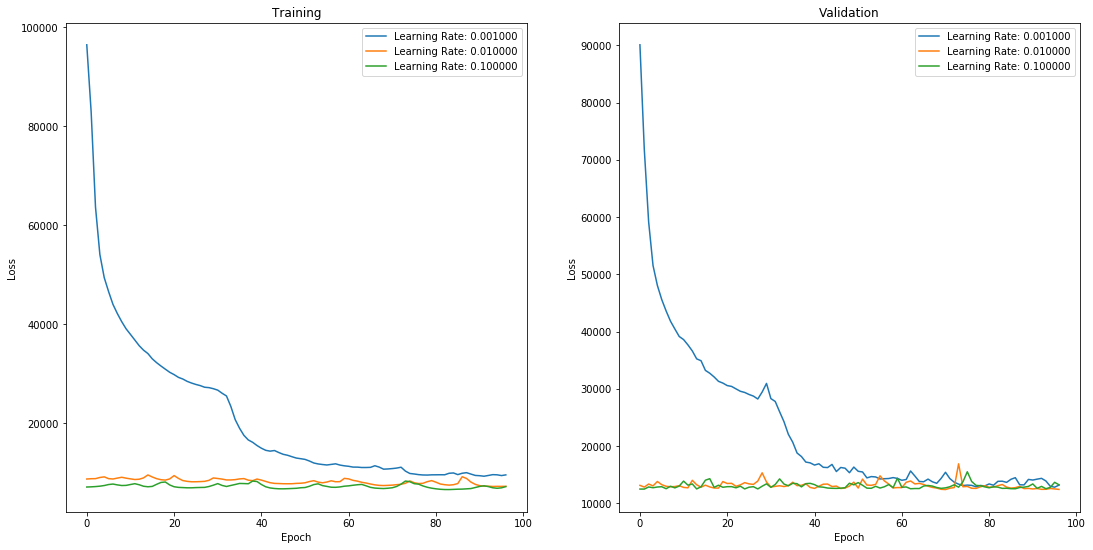

In [0]:
fig = plt.figure(figsize=(38, 9))
ax = fig.add_subplot(1,4,1)
# ax.set_ylim(0, 400000)

for i in range(len(learning_rates)): 
  plt.plot(results[i][3:], label="Learning Rate: %f" % (learning_rates[i]))
  
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1,4,2)
# ax.set_ylim(0, 400000)

for i in range(len(learning_rates)): 
  plt.plot(val_results[i][3:], label="Learning Rate: %f" % (learning_rates[i]))
  
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

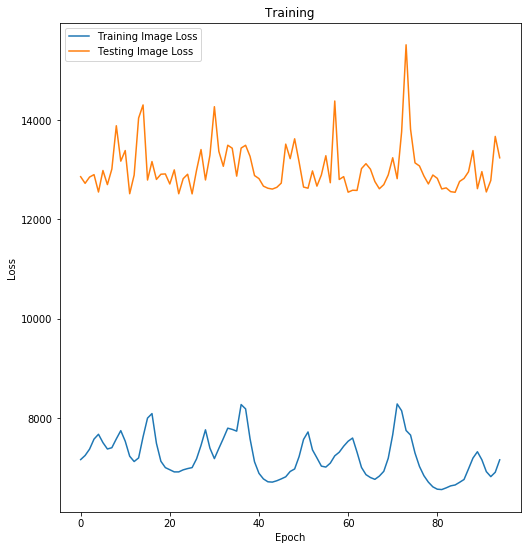

In [0]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Training")
plt.plot(history.history["loss"][5:], label="Training Image Loss")
plt.plot(history.history["val_loss"][5:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:
sample_z = encoder_conditional.predict(train_y)
result = decoder.predict([sample_z, train_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("Input")
#   plt.imshow(tf.image.grayscale_to_rgb(train_y[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

NameError: ignored

In [0]:
sample_z = encoder_conditional.predict(test_y)
result = decoder.predict([sample_z, test_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

In [0]:
# TODO: GET RID OF THESE INPUT CLIPPING MESSAGE

output_count = 12
index_offset = 0

diverse_colourisations = []
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  diverse_colourisations.append(result)

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+1]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+2]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+3]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+4]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+5]))